In [1]:
from mangaki.utils.svd import MangakiSVD
import numpy as np
import pandas 
from mangaki.utils.values import rating_values

ratings = pandas.read_csv('~/Bureau/ratings.csv', header=None).as_matrix()
works=pandas.read_csv('~/Bureau/works.csv', header=None).as_matrix()


In [2]:
svd =MangakiSVD(10)
X=ratings[:,0:2]
Y=[rating_values[rating] for rating in ratings[:,2]]
nb_users=X[:,0].max()+1
nb_items=X[:,1].max()+1
svd.set_parameters(nb_users,nb_items)
svd.fit(X,Y)

Computing M: (1855 × 8742)
fill and center matrix [1011 ms]
Shapes (1855, 10) (10,) (10, 8742)
factor matrix [36162 ms]


In [33]:
ratings[:,0] == 1242
ratings[ratings[:,0] == 1242]
ratings[ratings[:,0] == 1242, 1]


works2 = pandas.read_csv('~/Bureau/works.csv', header=None, names=['ID', 'Titre']).set_index('ID')

fravoi_favorite = ratings[(ratings[:,0] == 1242) & (ratings[:,2] == 'favorite'), 1].astype(np.int32)
fravoi_like = ratings[(ratings[:,0] == 1242) & (ratings[:,2] == 'like'), 1].astype(np.int32)
fravoi_dislike = ratings[(ratings[:,0] == 1242) & (ratings[:,2] == 'dislike'), 1].astype(np.int32)

<IPython.core.display.Javascript object>


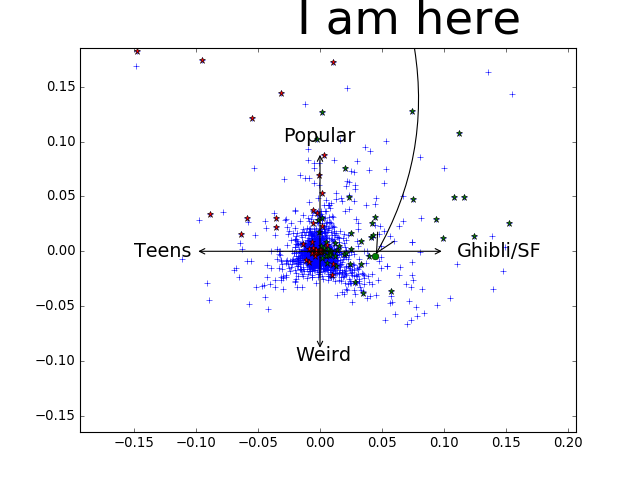

In [44]:
#Graphique pour les utilisateurs
%matplotlib notebook
import matplotlib.pyplot as plt

plt.clf()

#les axes
plt.annotate('', xy=(0, 0.09), xytext=(0, -0.09),arrowprops={'arrowstyle': '<->'})
plt.annotate('', xy=(0.1, 0), xytext=(-0.1, 0),arrowprops={'arrowstyle': '<->'})
#les annotations
plt.text(-0.03, 0.1, 'Popular', size='x-large')
plt.text(-0.02, -0.1, 'Weird', size='x-large')
plt.text(-0.15, -0.005, 'Teens', size='x-large')
plt.text(0.11, -0.005, 'Ghibli/SF', size='x-large')

works_pts = svd.VT
users_pts = svd.U

plt.plot(works_pts[0,:],works_pts[1,:],'+b') 

plt.plot(works_pts[0,fravoi_like],works_pts[1,fravoi_like], '*g')
plt.plot(works_pts[0,fravoi_dislike],works_pts[1,fravoi_dislike], '*r')


jjx, jjy = users_pts[1242,0], users_pts[1242,1]
plt.plot(jjx, jjy, 'og')
plt.annotate('I am here', size=42, xy=(jjx, jjy), xycoords='data',
                xytext=(-70, 200), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3,rad=-.2")
                )

<IPython.core.display.Javascript object>


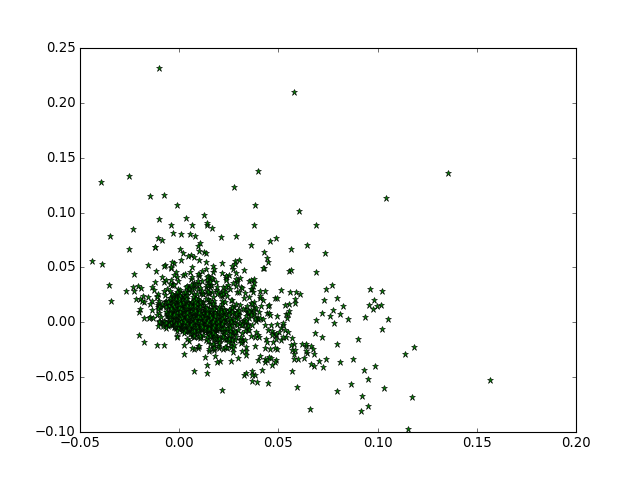

In [28]:
%matplotlib notebook

plt.plot(svd.U[:,0],svd.U[:,1],'*g')#anime

In [16]:
#recherche du top 1 du 1er vecteur
svd.VT[0,:].max() #recherche du max
svd.VT[0,:].argmax()#recherche de l'indice du max
works[svd.VT[0,:].argmax(),1]

'Princesse Mononoké'

In [1]:
#affichage du top 30 du 1er vecteur ligne de svd.VT
A=[svd.VT[0,i] for i in range(0, nb_items)]
A.sort()
B=svd.VT[0,:].tolist()
list_haut=[works[B.index(A[i]),1] for i in range(nb_items-30,nb_items)]
list_haut 

NameError: name 'nb_items' is not defined

In [ ]:
#Graphique pour les utilisateurs
%matplotlib notebook
import matplotlib.pyplot as plt

plt.clf()

#les axes
plt.annotate('', xy=(0, 0.09), xytext=(0, -0.09),arrowprops={'arrowstyle': '<->'})
plt.annotate('', xy=(0.1, 0), xytext=(-0.1, 0),arrowprops={'arrowstyle': '<->'})
#les annotations
plt.text(-0.03, 0.1, 'Populaire')
plt.text(-0.02, -0.1, 'Bizarre')
plt.text(-0.15, -0.005, 'Enfant')
plt.text(0.11, -0.005, 'SF')

plt.plot(svd.VT[0,:],svd.VT[1,:],'+b') 

# Un peu autre chose : DPP : determinential point process



Permet d'avoir des points moins proches les uns des autres pour permettre et proposer une meilleure variété d'animes

## Matrice de similarité

Méthode avec la mesure de cosine (cosinus)

In [13]:
#version bcp plus rapide
#TODO : enlever le calcul des éléments sur la diagonale qui ne sert à rien
#remplir la partie triangulaire inférieure par ce qu'il faut et 1 sur diag
#changer np.vdot en np.dot

import numpy as np
import pandas
from math import sqrt

#requiert une matrice SVD nommée SVD
#retourne une matrice de similarité similarity

def compute_similarity_coisine_test(SVD):
    nb_items = np.shape(SVD)[1]
    J = SVD.T.dot(SVD)
    D = np.sqrt(np.diag(J))
    similarity = J / D[:,np.newaxis].dot(D[np.newaxis,:])
    
    
    return similarity

similarity=compute_similarity_coisine_test(svd.VT)
similarity



In [18]:
from scipy.spatial.distance import pdist, squareform

def compute_similarity_coisine(SVD):
    return 1 - squareform(pdist(SVD.T, metric='cosine'))

similarity=compute_similarity_coisine(svd.VT)

Fonction effectuant le dpp en utilisant une matrice de similarité

In [19]:

def sample_k(items, L, k, max_nb_iterations=1000, rng=np.random):
    """
    Sample a list of k items from a DPP defined
    by the similarity matrix L. The algorithm
    is iterative and runs for max_nb_iterations.
    The algorithm used is from
    (Fast Determinantal Point Process Sampling withw
    Application to Clustering, Byungkon Kang, NIPS 2013)
    """
    initial = rng.choice(range(len(items)), size=k, replace=False)
    X = [False] * len(items)
    for i in initial:
        X[i] = True
    X = np.array(X)
    for i in range(max_nb_iterations):
        u = rng.choice(np.arange(len(items))[X])
        v = rng.choice(np.arange(len(items))[~X])
        Y = X.copy()
        Y[u] = False
        L_Y = L[Y, :]
        L_Y = L_Y[:, Y]
        L_Y_inv = np.linalg.inv(L_Y)

        c_v = L[v:v+1, :]
        c_v = c_v[:, v:v+1]
        b_v = L[Y, :]
        b_v = b_v[:, v:v+1]
        c_u = L[u:u+1, :]
        c_u = c_u[:, u:u+1]
        b_u = L[Y, :]
        b_u = b_u[:, u:u+1]

        p = min(1, c_v - np.dot(np.dot(b_v.T, L_Y_inv), b_v) /
                (c_u - np.dot(np.dot(b_u.T, L_Y_inv.T), b_u)))
        if rng.uniform() <= p:
            X = Y[:]
            X[v] = True
    return np.array(items)[X]

In [20]:
#liste de 10 éléments choisis en utilisant la dpp
items = range(0,nb_items)
sampled_items = sample_k(items, similarity, 10)

In [21]:
#liste de 10 éléments choisis aléatoirement
import random
uniform_items = list(range(similarity.shape[0]))
random.shuffle(uniform_items)
uniform_items = uniform_items[:10]

In [22]:
sampled_items, uniform_items

(array([ 929, 1126, 2483, 3511, 4460, 4858, 5163, 5340, 6674, 7700]),
 [2279, 5704, 8193, 1300, 6718, 3135, 1315, 7801, 472, 4580])

In [23]:
#comparaison de la somme obtenue des distances
from scipy.spatial.distance import pdist, squareform
pdist(svd.VT[:,sampled_items].T)


array([ 0.01453832,  0.01337374,  0.01591959,  0.01354588,  0.02220688,
        0.01379761,  0.03822021,  0.06170746,  0.01378267,  0.00284981,
        0.00301678,  0.00324088,  0.02868057,  0.00625895,  0.02783046,
        0.05574919,  0.00480877,  0.00394319,  0.00118354,  0.02849296,
        0.00520541,  0.02773898,  0.05528217,  0.00479217,  0.00455805,
        0.02985466,  0.00821625,  0.0268112 ,  0.05388675,  0.00736118,
        0.02855172,  0.00503737,  0.02719985,  0.05555382,  0.00404303,
        0.02902339,  0.05124819,  0.06247044,  0.0287166 ,  0.02845732,
        0.05706673,  0.00508751,  0.05297732,  0.02761067,  0.05795166])

In [24]:
(pdist(svd.VT[:,sampled_items].T)).sum()

1.117849905236632

In [25]:
(pdist(svd.VT[:,uniform_items].T)).sum()

1.3588277172286947

<IPython.core.display.Javascript object>


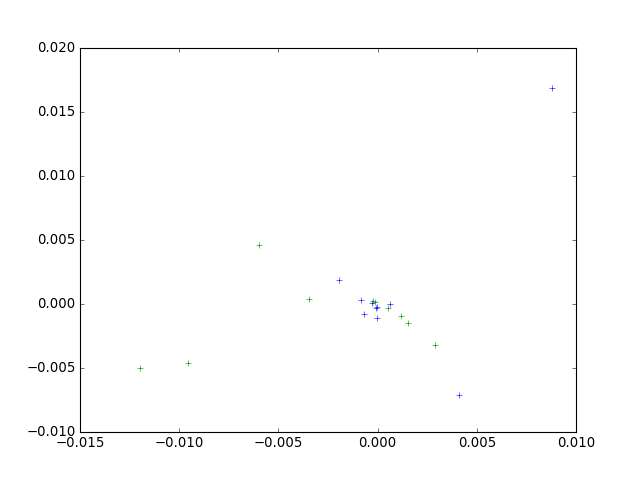

In [29]:
%matplotlib notebook
plt.clf()
plt.plot(svd.VT[0, sampled_items], svd.VT[1, sampled_items], '+b')
plt.plot(svd.VT[0, uniform_items], svd.VT[1, uniform_items], '+g')

In [30]:
#comparaison des animes contenus dans chacune des listes
print('\n'.join(works[sampled_items,1]))

Sweet Little Devil
Arc the Lad
To Heart: Remember My Memories Specials
Ranma ½: 1994 Music Calendar
Penguin Musume♥Heart
Dark Crimson
K: Return of Kings
The Animatrix
Ubel blatt
Mikakunin de Shinkoukei OVA


In [31]:
print('\n'.join(works[uniform_items,1]))

Touch: Miss Lonely Yesterday - Are kara, Kimi wa...
Tom Sawyer no Bouken Specials
Yatterman
Naruto the Movie 3: Guardians of the Crescent Moon Kingdom
Sailor Moon
Rose de Versailles (la)
Gokusen
Ghiblies
Naruzozo
Golden Time


In [32]:
from scipy.spatial.distance import pdist, squareform

1 - squareform(pdist(svd.VT.T, metric='cosine'))

array([[ 1.        ,  0.08471437, -0.56138472, ...,  0.14679545,
        -0.68534132,  0.00383582],
       [ 0.08471437,  1.        , -0.07371975, ...,  0.03701757,
        -0.0280354 ,  0.91589537],
       [-0.56138472, -0.07371975,  1.        , ..., -0.03505325,
         0.09011494,  0.15850288],
       ..., 
       [ 0.14679545,  0.03701757, -0.03505325, ...,  1.        ,
         0.11731634, -0.00233954],
       [-0.68534132, -0.0280354 ,  0.09011494, ...,  0.11731634,
         1.        ,  0.05507686],
       [ 0.00383582,  0.91589537,  0.15850288, ..., -0.00233954,
         0.05507686,  1.        ]])

# En cours, non fini, nbreux bugs


 Autre matrice de similarité en utilisant le Jaccard index

In [29]:
import pandas
import numpy as np
from scipy.sparse import csc_matrix

ratings = pandas.read_csv('../data/ratings.csv', header=None).as_matrix()
works=pandas.read_csv('../data/works.csv', header=None).as_matrix()

X=ratings[:,0:2]
nb_users=X[:,0].max()+1
nb_items=X[:,1].max()+1


row=ratings[:,0]
col=ratings[:,1]
rating_values = {'favorite': 2, 'like': 2, 'dislike': -2, 'neutral': 0.1, 'willsee': 0.5, 'wontsee': -0.5}
data=np.array([rating_values[rating] for rating in ratings[:,2]])
entry=csc_matrix((data, (row, col)), shape=(nb_users, nb_items)).toarray()#création de la "matrice creuse" user*item


array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  2. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ])

In [ ]:
#requiert une matrice user*item entry
#essayer de le faire matriciellement
#retourne une matrice de similarité similarity

def compute_similarity_jaccard(entry):
    
    nb_items = np.shape(entry)[1]
    similarity=np.zeros([nb_items,nb_items])
    for i in range(0,nb_items):
        for j in range(i+1,nb_items):
            vecteur=entry[:,i]*entry[:,j]
            nb_agree=vecteur.tolist().count(4)
            if nb_agree==0 :
                similarity[i,j]=0
            else :
                nb_disagree=nb_agree+vecteur.tolist().count(-4)
                similarity[i,j]=nb_agree/nb_disagree
             
    #! partie triangulaire inf à faire
    return similarity
A=compute_similarity_jaccard(entry)
B=cosine=compute_similarity_coisine(entry)
A

In [ ]:

B
